# Group Project Report: Maternal Health Risk Classification

Members: Ruby Liu, Yu Wei Chen, Annabel Lim, Heather Jia

## Introduction

### Background Information

Depending on a number of factors, a pregnancy can be considered “high-risk”. A high-risk pregnancy means that both mother and child are more likely to have health problems, requiring special monitoring to ensure the least amount of harm. It is important to know whether a mother is high-risk, so medical professionals can take the necessary preventative measures to ensure the health of both the mother and baby. 

### Project Question

Can we use the maternal risk factor measurements (age, systolic blood pressure, diastolic blood pressure, and blood sugar level) provided in our data to predict whether someone who is pregnant is at high risk, mid-risk, or low risk of maternal mortality? 

### Data Set

We will be using the Maternal Health Risk Data Set from the UCI Machine Learning Repository. The data was collected from hospitals, community clinics, and maternal health care centres from the rural areas of Bangladesh where region-specific studies have found that 1 in 10 pregnant women have low blood glucose levels. There are columns for age, systolic blood pressure, diastolic blood pressure, blood sugar, body temperature, heart rate, and risk level.


## Methods and Results 

In [77]:
# load libraries 
library(tidyverse)
library(tidymodels)

# set seed value
set.seed(5);

In [78]:
# data set url
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00639/Maternal%20Health%20Risk%20Data%20Set.csv"

# read data 
maternity_data <- read_csv(url) |>
    mutate(RiskLevel = as_factor(RiskLevel))
head(maternity_data)

Rows: 1014 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): RiskLevel
dbl (6): Age, SystolicBP, DiastolicBP, BS, BodyTemp, HeartRate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
25,130,80,15.00,98,86,high risk
35,140,90,13.00,98,70,high risk
29,90,70,8.00,100,80,high risk
30,140,85,7.00,98,70,high risk
35,120,60,6.10,98,76,low risk
23,140,80,7.01,98,70,high risk


In [79]:
# keep predictors: Age, Systolic Blood Pressure, Diastolic Blood Pressure, Blood Sugar
# target variable: Risk Level 
maternity_selected <- maternity_data |>
    select(Age, DiastolicBP, SystolicBP, BS, RiskLevel)
head(maternity_selected)

Age,DiastolicBP,SystolicBP,BS,RiskLevel
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
25,80,130,15.00,high risk
35,90,140,13.00,high risk
29,70,90,8.00,high risk
30,85,140,7.00,high risk
35,60,120,6.10,low risk
23,80,140,7.01,high risk


In [97]:
set.seed(5);

# split data by 75% training, 25% testing 
maternity_split <- initial_split(maternity_selected, prop = 0.75, strata = RiskLevel) 

# training set 
maternity_train <- training(maternity_split)

# testing set
maternity_test <- testing(maternity_split)

head(maternity_train)
head(maternity_test)

Age,DiastolicBP,SystolicBP,BS,RiskLevel
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
25,80,130,15.00,high risk
35,90,140,13.00,high risk
29,70,90,8.00,high risk
30,85,140,7.00,high risk
23,80,140,7.01,high risk
35,60,85,11.00,high risk


Age,DiastolicBP,SystolicBP,BS,RiskLevel
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
23,70,130,7.01,mid risk
32,90,120,6.90,mid risk
42,80,130,18.00,high risk
25,89,110,7.01,low risk
16,70,100,7.20,low risk
20,90,100,7.10,low risk


In [98]:
# find proportions of labels
maternity_proportions <- maternity_train |>
    group_by(RiskLevel) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(maternity_train))

maternity_proportions

# find mean of each predictor
maternity_predictor_means <- maternity_train |>
    select(- RiskLevel) |>
    map_df(mean)

maternity_predictor_means

RiskLevel,n,percent
<fct>,<int>,<dbl>
high risk,204,26.84211
low risk,304,40.00000
mid risk,252,33.15789


Age,DiastolicBP,SystolicBP,BS
<dbl>,<dbl>,<dbl>,<dbl>
29.58158,76.52895,113.0355,8.722921


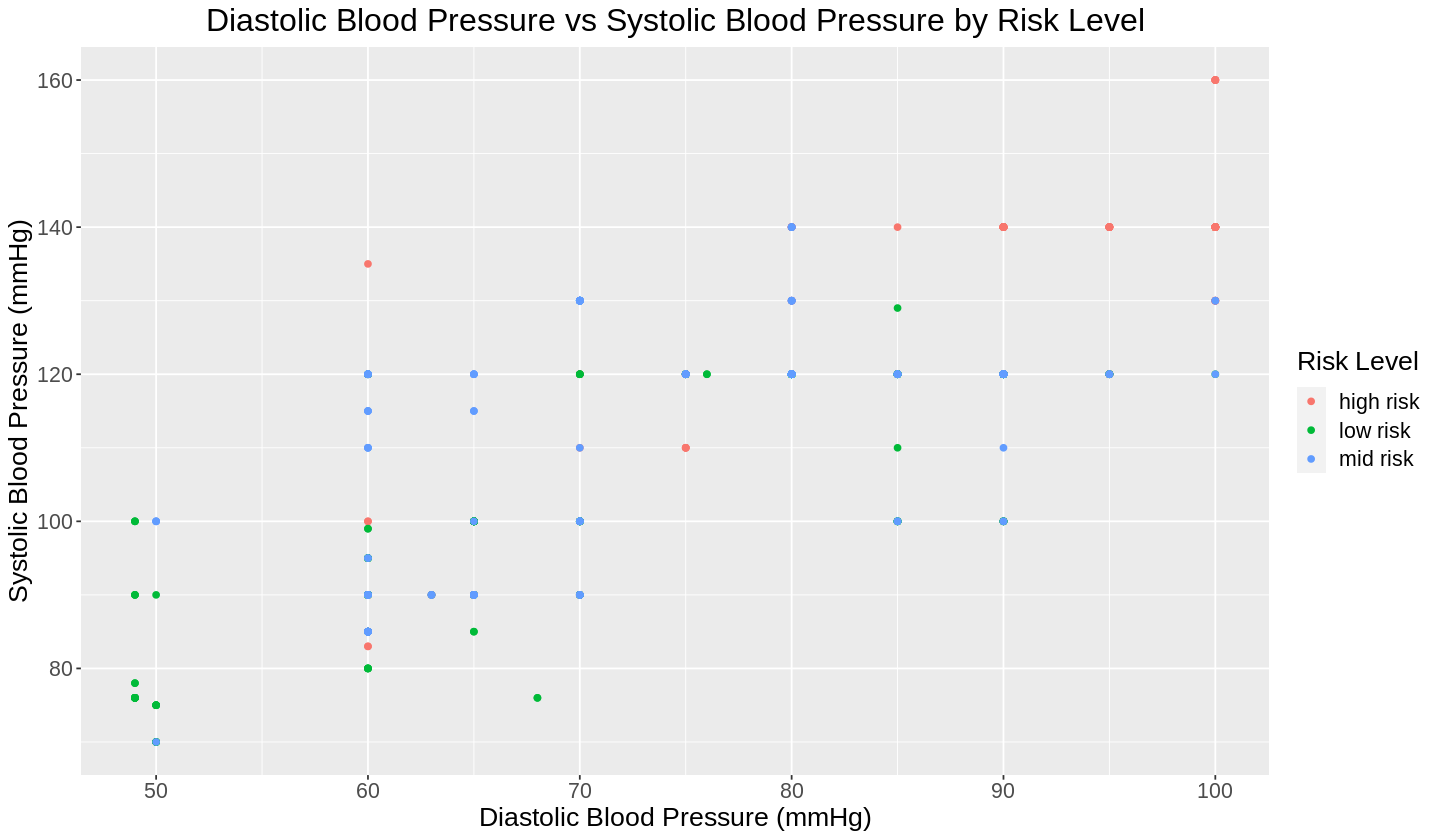

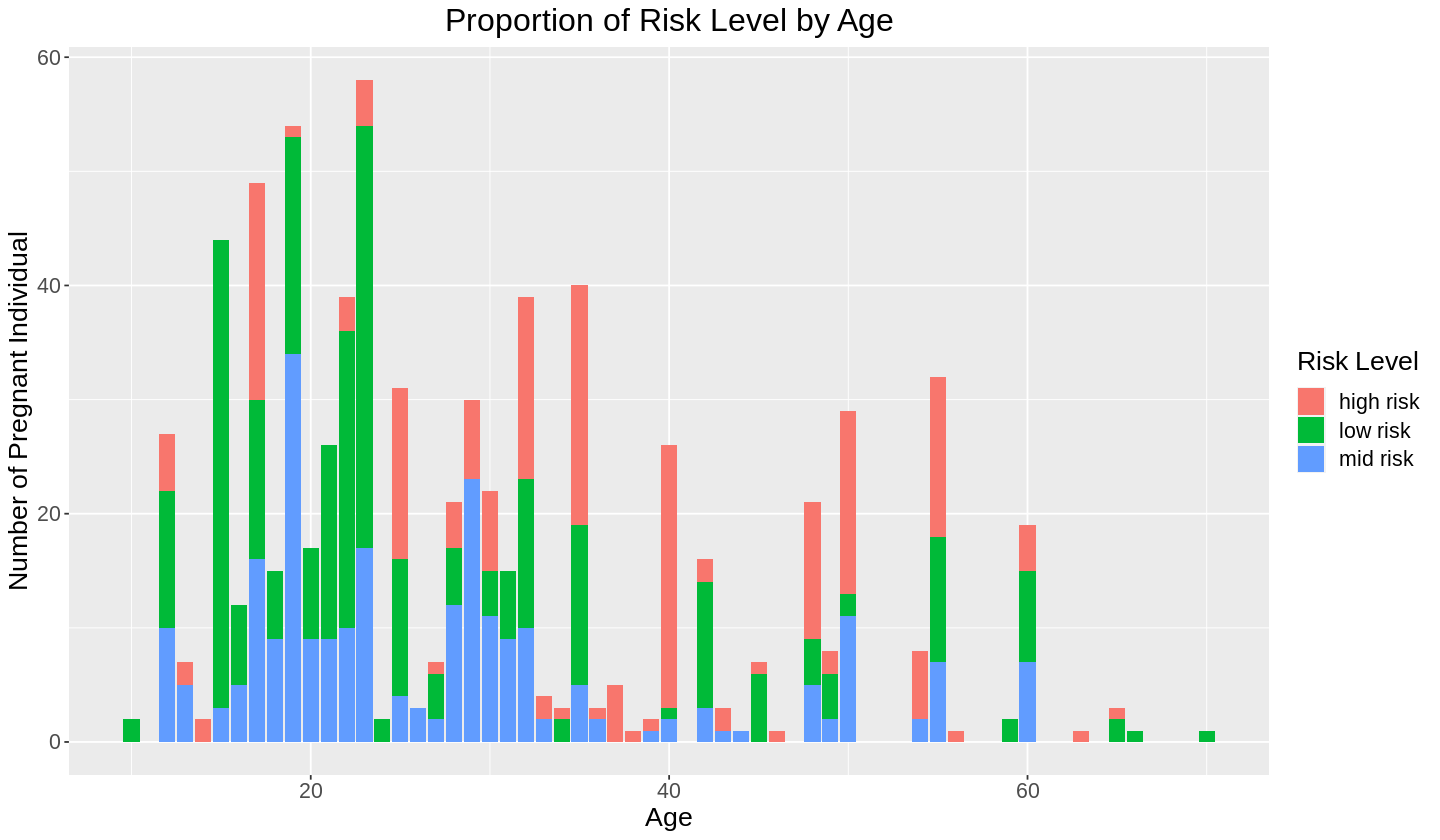

In [99]:
options(repr.plot.width = 12, repr.plot.height = 7)

# plot diastolic BP vs systolic BP, color by risk level
maternity_diastolic_vs_systolic <- maternity_train |>
    ggplot(aes(x = DiastolicBP, y = SystolicBP, color = RiskLevel)) +
        geom_point() +
        labs (x = "Diastolic Blood Pressure (mmHg)", y = "Systolic Blood Pressure (mmHg)", color = "Risk Level") +
        ggtitle("Diastolic Blood Pressure vs Systolic Blood Pressure by Risk Level") +
        theme(text = element_text(size = 16)) +
        theme(plot.title = element_text(hjust = 0.5))

maternity_diastolic_vs_systolic

# plot proportion of risk level based on age 
maternity_age_vs_risk <- maternity_train |>
    ggplot(aes(x = Age, fill = RiskLevel)) +
        geom_bar() +
        labs(x = "Age", y = "Number of Pregnant Individual", fill = "Risk Level") +
        ggtitle("Proportion of Risk Level by Age") +
        theme(text = element_text(size = 16)) +
        theme(plot.title = element_text(hjust = 0.5))

maternity_age_vs_risk

In [100]:
# create recipe with all predictors
maternity_recipe <- recipe(RiskLevel ~., data = maternity_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# create knn model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# perform 5 fold cross validation on training set
train_vfold <- vfold_cv(maternity_train, v=5, strata = RiskLevel) 

# create data frame where k = 1 to 10
k_vals <- tibble(neighbors = seq(from = 1, to = 10))

In [101]:
# use workflow to combine recipe + model spec
# then tune model using tune_grid and collect metrics
knn_results <- workflow() |>
    add_recipe(maternity_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = train_vfold, grid = k_vals) |>
    collect_metrics()

# get accuracy from metrics on fitted model 
accuracies <- knn_results |>
    filter(.metric == "accuracy") 

head(accuracies)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.7815948,5,0.02229160,Preprocessor1_Model01
2,accuracy,multiclass,0.7604795,5,0.02186257,Preprocessor1_Model02
3,accuracy,multiclass,0.7185112,5,0.01562014,Preprocessor1_Model03
4,accuracy,multiclass,0.7133003,5,0.02141983,Preprocessor1_Model04
5,accuracy,multiclass,0.7225986,5,0.02506702,Preprocessor1_Model05
6,accuracy,multiclass,0.7238442,5,0.01963906,Preprocessor1_Model06


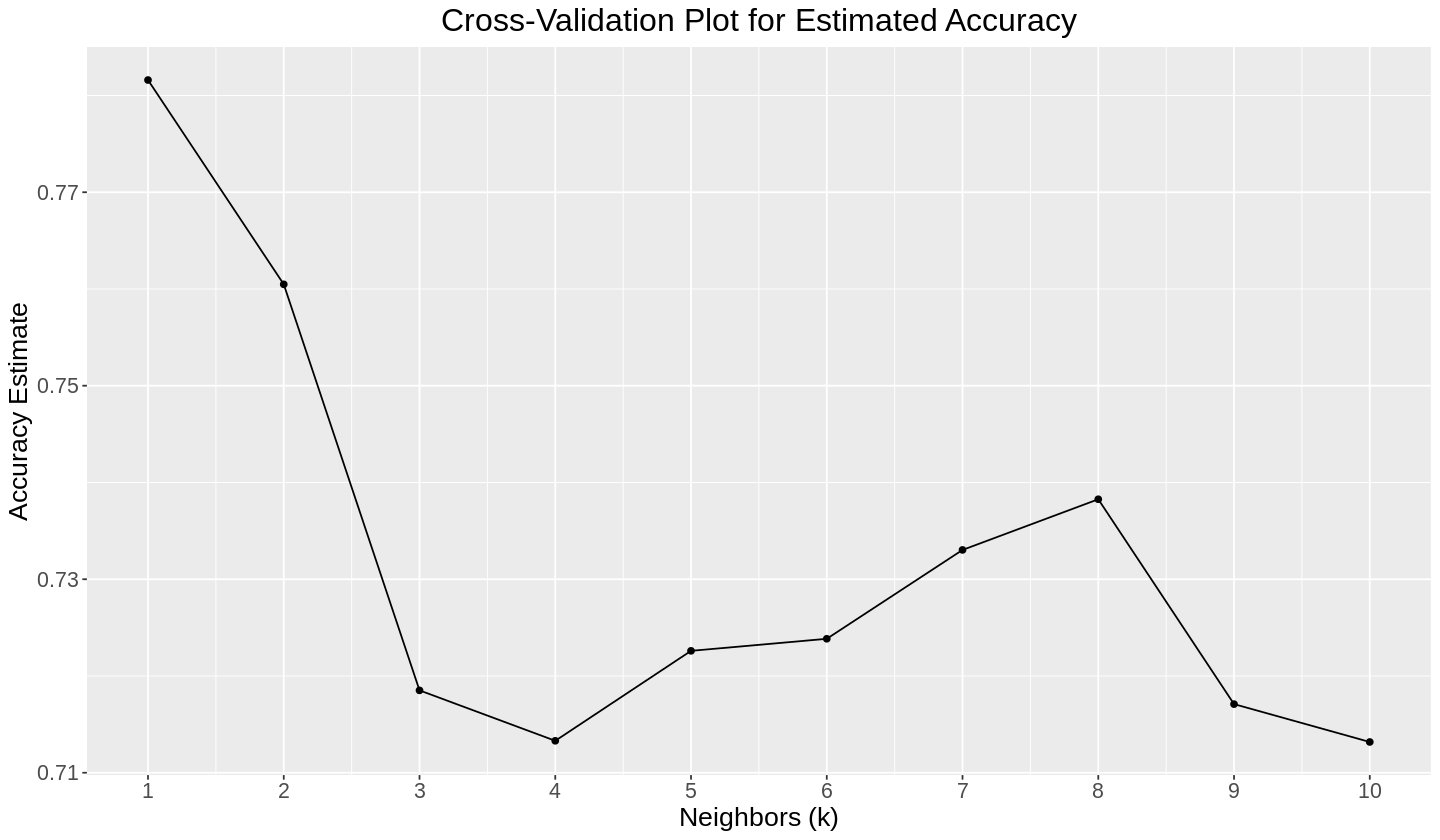

In [102]:
# plot k (neighbors) vs accuracy (mean)
cross_val_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Neighbors (k)", y = "Accuracy Estimate") +
        ggtitle("Cross-Validation Plot for Estimated Accuracy") +
        scale_x_continuous(breaks = 1:10) +
        theme(text = element_text(size = 16)) +
        theme(plot.title = element_text(hjust = 0.5))

# can estimate and view which k value may be the best
cross_val_plot

In [103]:
# choose k = 2

# create knn model specification with chosen k
final_spec <- nearest_neighbor(weight_func = "rectangular",
                               neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

# analysis
final_results <- workflow() |>
    add_recipe(maternity_recipe) |>
    add_model(final_spec) |>
    fit(data = maternity_train) |>
    predict(maternity_test) |>
    bind_cols(maternity_test)

# extracting model's accuracy
final_accuracy <- final_results |>
    metrics(truth = RiskLevel, estimate = .pred_class) |>
    filter(.metric == "accuracy")
final_accuracy

# extracting model's confusion matrix
final_conf_mat <- final_results |>
    conf_mat(truth = RiskLevel, estimate = .pred_class)
final_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7755906


           Truth
Prediction  high risk low risk mid risk
  high risk        61        4        6
  low risk          2       82       24
  mid risk          5       16       54

## Discussion

## References 